In [ ]:
# Run if nltk not installed
# import nltk
# nltk.download('all')

In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn import metrics
import matplotlib.pyplot as plt
import string, re, emoji
import random

# Limpieza de textos
from pattern.text.es import singularize, lemma
from nltk.corpus import stopwords

from wordcloud import WordCloud

# Sentimientos
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer

pd.options.display.max_rows = 10
import time

In [4]:
train = pd.read_csv('./train.csv', encoding='utf8')
cachedStopWords = stopwords.words('spanish')

In [5]:
train.columns

Index(['userName', 'userLocation', 'userDescription', 'isUserVerified', 'date',
       'text', 'source'],
      dtype='object')

# Analisis Exploratorio I

<AxesSubplot:>

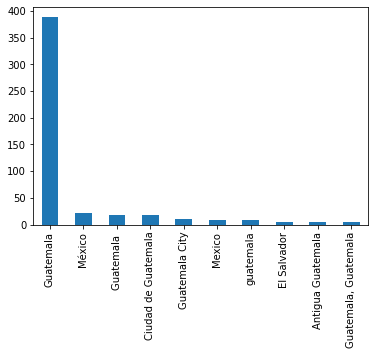

In [21]:
train['userLocation'].value_counts().head(10).plot.bar()

False    1489
True       11
Name: isUserVerified, dtype: int64


<AxesSubplot:>

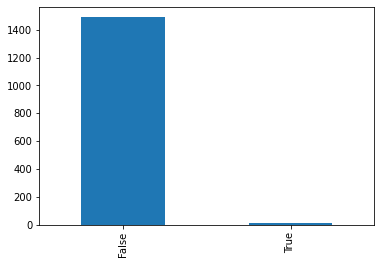

In [23]:
print(train['isUserVerified'].value_counts())
train['isUserVerified'].value_counts().head(10).plot.bar()

<AxesSubplot:>

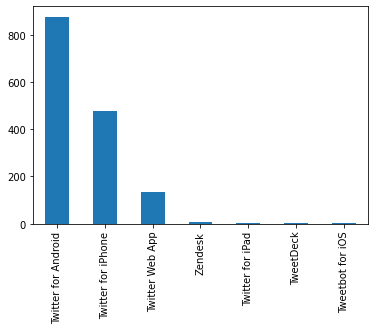

In [24]:
train['source'].value_counts().head(10).plot.bar()

In [32]:
train

,userName,userLocation,userDescription,isUserVerified,date,text,source,cleanText
0,Lourdes Benavente,Latitud flor y granizo,Ingeniera Ambiental de profesión y ambientalis...,False,2022-09-11 17:17:22+00:00,Aparece el 5G y la red de tigo ya no sirve par...,Twitter for Android,aparecer 5g rer tigar servir
1,Mariela,Guatemala,"Una bad bitch, girl de lo' 90",False,2022-09-11 17:05:36+00:00,@Tigo_GT Entregarte tanto fue mi debilidad\nY ...,Twitter for iPhone,entregarter debilidar besar ahorarr necesidar ...
2,Mariela,Guatemala,"Una bad bitch, girl de lo' 90",False,2022-09-11 17:05:24+00:00,@Tigo_GT Entregarte tanto fue mi debilidad\nY ...,Twitter for iPhone,entregarter debilidar besar ahorarr necesidar ...
3,Mariela,Guatemala,"Una bad bitch, girl de lo' 90",False,2022-09-11 17:05:00+00:00,@Tigo_GT Entregarte tanto fue mi debilidad\nY ...,Twitter for iPhone,entregarter debilidar besar ahorarr necesidar ...
4,Griffith91,NaN,Blueworld,False,2022-09-11 16:30:06+00:00,@Tigo_GT 👑👑👑👑Super Junior 👑👑👑👑🇬🇹🇬🇹🇬🇹🇬🇹💙💙💙💙💙💙💙💙...,Twitter for Android,super junior
...,...,...,...,...,...,...,...,...
1495,💚Loͦvͮeͤs͛ Dͩeͤnniͥs͛💚🌿,NaN,cuenta fan ☀ ❂ (@_dennisarana) ❂ ☀. ...,False,2022-09-06 23:38:23+00:00,@Tigo_GT @Dennistas_club @_DennisArana @Team_D...,Twitter for Android,amar todar favoritar vez krum
1496,Jackie 🤍💚Ohana💚🤍,México,"Apoyo 100% al mejor artista, al mas completo e...",False,2022-09-06 23:38:01+00:00,@Tigo_GT @_DennisArana @Team_Dennis @Dennistas...,Twitter for Android,q gustar variar difícil decidir increíbler voz...
1497,TeamDennisUSA 🇺🇸,NaN,Cuenta de apoyo para @_dennisarana Somos una O...,False,2022-09-06 23:38:00+00:00,@Tigo_GT @_DennisArana @Team_Dennis @Dennistas...,Twitter for iPhone,fav x siemprer románticonar
1498,Dennistas_fansclub✨,NaN,Página de apoyo al niño más lindo del mundo @_...,False,2022-09-06 23:37:51+00:00,@Tigo_GT @_DennisArana @Team_Dennis @Dennistas...,Twitter for Android,encantar todar verdaderamenter pr soñar fav fav


# Limpieza de datos

In [14]:
def toSingular(value):
  try:
    return singularize(value)
  except:
    return value

def parseLemma(value):
  try:
    return lemma(value)
  except:
    return value

def replaceSpace(value):
  return str(value).replace('%20', ' ')

def removeHastags(value):
  if ('#' not in value): return value
  hashtags = re.findall(r"#[^\s]*", value, re.I)
  for hashtag in hashtags:
    value = value.replace(hashtag, '')
  return value

def removeLinks(value):
  if ('http' not in value): return value
  links = re.findall(r"http[^\s]*", value, re.I)
  for link in links:
    value = value.replace(link, '')
  return value

def removeStepWords(value):
  return ' '.join([word for word in value.split() if word not in cachedStopWords])

def extractEmojis(value):
  return emoji.replace_emoji(value, '')

def sentenceToSingular(value):
  items = value.split(' ')
  for item in items:
    singular = toSingular(item)
    value = value.replace(item, singular)
  return value

def sentenceToPresent(value):
  items = value.split(' ')
  for item in items:
    present = parseLemma(item)
    value = value.replace(item, present)
  return value

translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))

cleanText = []
for index, row in train.iterrows():
  text = row['text'][:]

  # Limpiando el texto
  text = text.lower()                         # Convierte todo a minusculas
  text = text.replace('utc', ' ')             # Quita utc
  text = text.replace('\n', ' ')              # Quita \n

  # Quita menciones
  hashtags = re.findall(r"#\S+", text, re.I)
  if (len(hashtags) > 0):
    for hashtag in hashtags:
      text = text.replace(hashtag, '')

  # Quita menciones
  mentions = re.findall(r"@\S+", text, re.I)
  if (len(mentions) > 0):
    for mention in mentions:
      text = text.replace(mention, '')
  
  text = removeLinks(text)                    # Quita links
  text = extractEmojis(text)                  # Quita todos los emojis
  text = text.translate(translator)           # Quita todos los signos de puntuacion
  text = removeStepWords(text)                # Quita todas las step words
  text = re.sub('  +', ' ', text)             # Quita todos los espacios de mas
  text = sentenceToSingular(text)             # Pasa las palabras a singular
  text = sentenceToPresent(text)              # Pasa las palabras a presente
  
  # Quitando numeros, pero algo como 5g no se elminara
  numbers = re.findall(r"[0-9]+\s", text, re.I)
  if (len(numbers) > 0):
    for number in numbers:
      text = text.replace(number, '')

  text = removeStepWords(text)                # Quita todas las step words
  text = re.sub('  +', ' ', text)             # Quita todos los espacios de mas

  cleanText.append(text)

train['cleanText'] = cleanText[:]

In [20]:
train

,userName,userLocation,userDescription,isUserVerified,date,text,source,cleanText
0,Lourdes Benavente,Latitud flor y granizo,Ingeniera Ambiental de profesión y ambientalis...,False,2022-09-11 17:17:22+00:00,Aparece el 5G y la red de tigo ya no sirve par...,Twitter for Android,aparecer 5g rer tigar servir
1,Mariela,Guatemala,"Una bad bitch, girl de lo' 90",False,2022-09-11 17:05:36+00:00,@Tigo_GT Entregarte tanto fue mi debilidad\nY ...,Twitter for iPhone,entregarter debilidar besar ahorarr necesidar ...
2,Mariela,Guatemala,"Una bad bitch, girl de lo' 90",False,2022-09-11 17:05:24+00:00,@Tigo_GT Entregarte tanto fue mi debilidad\nY ...,Twitter for iPhone,entregarter debilidar besar ahorarr necesidar ...
3,Mariela,Guatemala,"Una bad bitch, girl de lo' 90",False,2022-09-11 17:05:00+00:00,@Tigo_GT Entregarte tanto fue mi debilidad\nY ...,Twitter for iPhone,entregarter debilidar besar ahorarr necesidar ...
4,Griffith91,NaN,Blueworld,False,2022-09-11 16:30:06+00:00,@Tigo_GT 👑👑👑👑Super Junior 👑👑👑👑🇬🇹🇬🇹🇬🇹🇬🇹💙💙💙💙💙💙💙💙...,Twitter for Android,super junior
...,...,...,...,...,...,...,...,...
1495,💚Loͦvͮeͤs͛ Dͩeͤnniͥs͛💚🌿,NaN,cuenta fan ☀ ❂ (@_dennisarana) ❂ ☀. ...,False,2022-09-06 23:38:23+00:00,@Tigo_GT @Dennistas_club @_DennisArana @Team_D...,Twitter for Android,amar todar favoritar vez krum
1496,Jackie 🤍💚Ohana💚🤍,México,"Apoyo 100% al mejor artista, al mas completo e...",False,2022-09-06 23:38:01+00:00,@Tigo_GT @_DennisArana @Team_Dennis @Dennistas...,Twitter for Android,q gustar variar difícil decidir increíbler voz...
1497,TeamDennisUSA 🇺🇸,NaN,Cuenta de apoyo para @_dennisarana Somos una O...,False,2022-09-06 23:38:00+00:00,@Tigo_GT @_DennisArana @Team_Dennis @Dennistas...,Twitter for iPhone,fav x siemprer románticonar
1498,Dennistas_fansclub✨,NaN,Página de apoyo al niño más lindo del mundo @_...,False,2022-09-06 23:37:51+00:00,@Tigo_GT @_DennisArana @Team_Dennis @Dennistas...,Twitter for Android,encantar todar verdaderamenter pr soñar fav fav


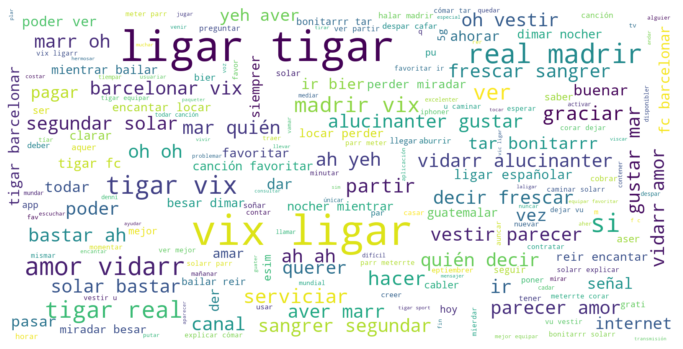

In [18]:
#Disaster Tweets wordcloud 
disaster_tweets = train[:]
disaster_string = []
for t in disaster_tweets.cleanText:
    disaster_string.append(t)
disaster_string = pd.Series(disaster_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=100, background_color='white').generate(disaster_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Sentimientos

In [35]:
def classifyTweet(dfToClassify):
    subjectivityValues = []
    positiveValues = []
    polarityValues = []

    for text in dfToClassify.cleanText:
        sent = TextBlob(text)
        subjectivity  = sent.sentiment.subjectivity
        polarity  = sent.sentiment.polarity

        sent = TextBlob(text, analyzer = NaiveBayesAnalyzer())
        classification = sent.sentiment.classification
        positiveScore = sent.sentiment.p_pos

        polarityValues.append(polarity)
        subjectivityValues.append(subjectivity)
        positiveValues.append(positiveScore)
    
    return [polarityValues, subjectivityValues, positiveValues]

In [43]:
exploratory = train.sample(307)

In [44]:
polarityValues, subjectivityValues, positiveValues = classifyTweet(exploratory)

In [45]:
exploratory['polarityValues'] = polarityValues
exploratory['subjectivity'] = subjectivityValues
exploratory['positive'] = positiveValues

In [48]:
exploratory.describe()

,polarityValues,subjectivity,positive
count,307.000000,307.000000,307.000000
mean,0.020467,0.032465,0.517027
std,0.091555,0.107343,0.090423
min,-0.400000,0.000000,0.100000
25%,0.000000,0.000000,0.500000
50%,0.000000,0.000000,0.500000
75%,0.000000,0.000000,0.516568
max,1.000000,0.900000,0.877143
